In [1]:
import json
import pandas as pd
#___________________________
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries',
                    'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#___________________________
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#___________________
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews']
#____________________________________
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}
#_____________________________________________________
IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}
#_____________________________________________________
def safe_access(container, index_values):
    # return missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan
#_____________________________________________________
def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])
#_____________________________________________________
def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])
#_____________________________________________________
def convert_to_original_format(movies, credits):
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from wordcloud import WordCloud, STOPWORDS
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')
PS = nltk.stem.PorterStemmer()
#__________________
# load the dataset
credits = load_tmdb_credits("tmdb_5000_credits.csv")
movies = load_tmdb_movies("tmdb_5000_movies.csv")
df_initial = convert_to_original_format(movies, credits)
print('Shape:',df_initial.shape)
#__________________________________________
# info on variable types and filling factor
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

Shape: (4803, 26)


,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
column type,int64,object,object,int64,object,object,object,object,float64,object,object,object,int64,float64,object,object,object,object,float64,int64,float64,object,object,object,object,object
null values,0,0,3091,0,0,86,0,3,0,0,0,1,0,2,0,0,844,0,0,0,1,174,30,53,63,93
null values (%),0,0,64.3556,0,0,1.79055,0,0.062461,0,0,0,0.0208203,0,0.0416406,0,0,17.5724,0,0,0,0.0208203,3.62274,0.62461,1.10348,1.31168,1.93629


In [3]:
set_keywords = set()
for liste_keywords in df_initial['plot_keywords'].str.split('|').values:
    if isinstance(liste_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)
#_________________________
# remove null chain entry
set_keywords.remove('')

In [4]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [5]:
keyword_occurences, dum = count_word(df_initial, 'plot_keywords', set_keywords)
keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 189]]

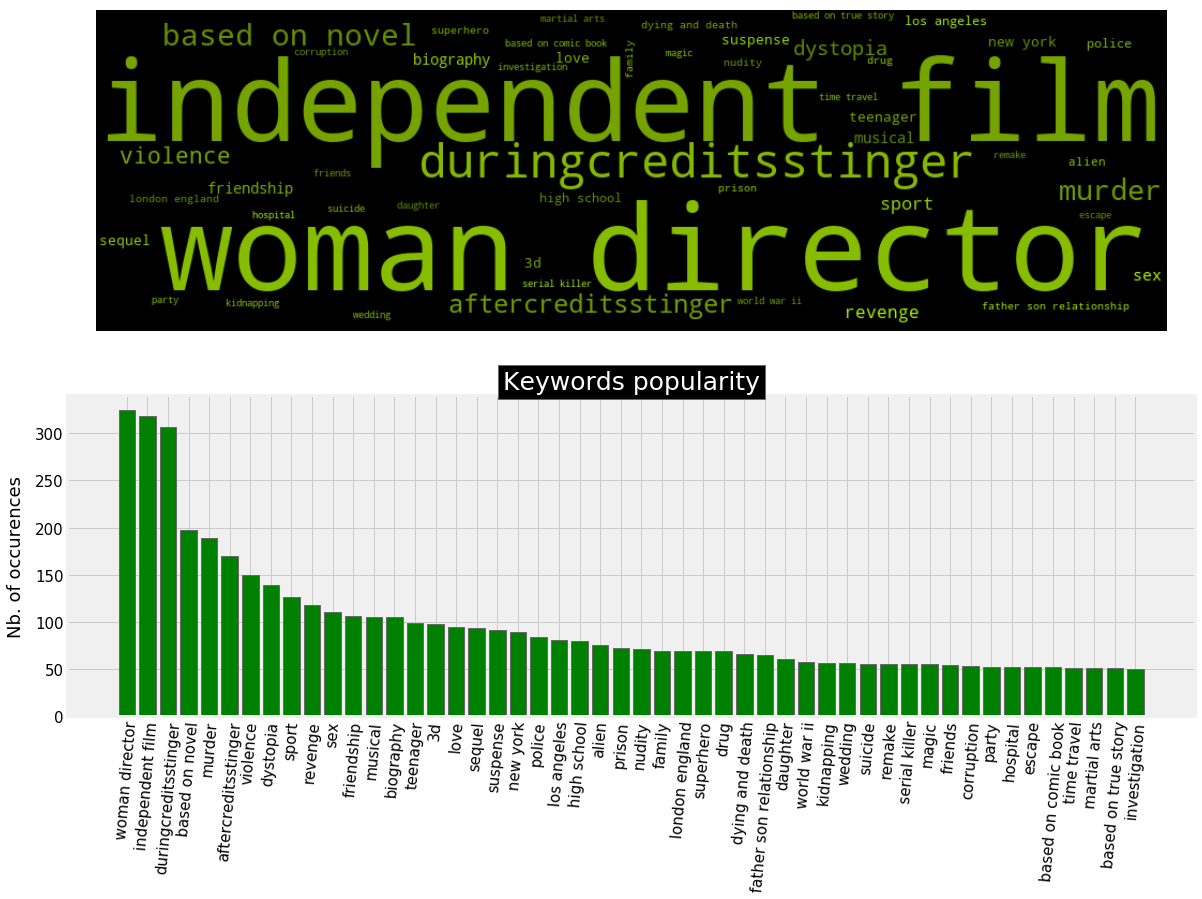

In [6]:
#_____________________________________________
# Function that control the color of the words
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# WARNING: the scope of variables is used to get the value of the "tone" variable
# I could not find the way to pass it as a parameter of "random_color_func()"
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#_____________________________________________
# UPPER PANEL: WORDCLOUD
fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)
#_______________________________________________________
# I define the dictionary used to produce the wordcloud
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 55.0 # define the color of the words
#________________________________________________________
wordcloud = WordCloud(width=1000,height=300, background_color='black', 
                      max_words=1628,relative_scaling=1,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')
#_____________________________________________
# LOWER PANEL: HISTOGRAMS
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
#_______________________
plt.title("Keywords popularity",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

In [7]:
missing_df = df_initial.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df_initial.shape[0] 
                                - missing_df['missing_count']) / df_initial.shape[0] * 100
missing_df.sort_values('filling_factor').reset_index(drop = True)

,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3_name,93,98.063710
4,language,86,98.209452
5,actor_2_name,63,98.688320
6,actor_1_name,53,98.896523
7,director_name,30,99.375390
8,overview,3,99.937539
9,duration,2,99.958359


In [8]:
df_initial['decade'] = df_initial['title_year'].apply(lambda x:((x-1900)//10)*10)
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(gr):
    return {'min':gr.min(),'max':gr.max(),'count': gr.count(),'mean':gr.mean()}
#______________________________________________________________
# Creation of a dataframe with statitical infos on each decade:
test = df_initial['title_year'].groupby(df_initial['decade']).apply(get_stats).unstack()

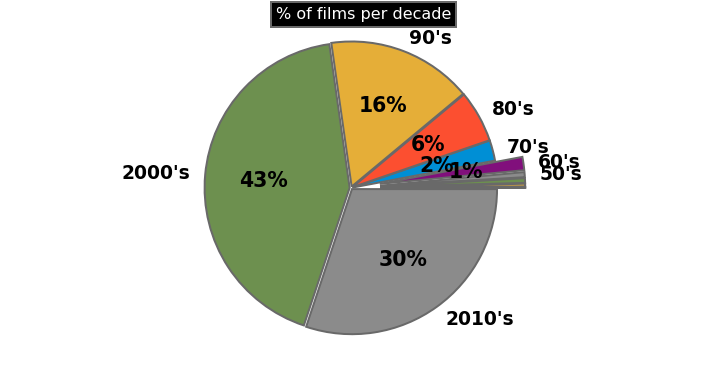

In [9]:

sns.set_context("poster", font_scale=0.85)
#_______________________________
# funtion used to set the labels
def label(s):
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine
#____________________________________
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
labels = [label(s) for s in  test.index]
sizes  = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(11)]
ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('% of films per decade',
             bbox={'facecolor':'k', 'pad':5},color='w', fontsize=16);
df_initial.drop('decade', axis=1, inplace = True)

In [10]:
genre_labels = set()
for s in df_initial['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [11]:
keyword_occurences, dum = count_word(df_initial, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 2297],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894]]

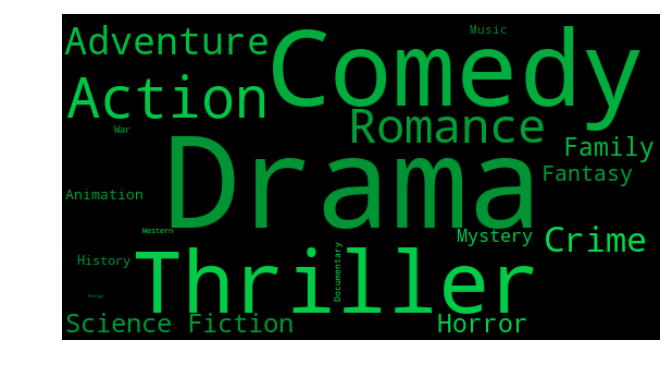

In [12]:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [13]:
df_duplicate_cleaned = df_initial


In [14]:
# Collect the keywords
#----------------------
def keywords_inventory(dataframe, colonne = 'plot_keywords'):
    PS = nltk.stem.PorterStemmer()
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys = []
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        for t in s.split('|'):
            t = t.lower() ; racine = PS.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
            else:
                keywords_roots[racine] = {t}
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select

In [15]:
keywords, keywords_roots, keywords_select = keywords_inventory(df_duplicate_cleaned,
                                                               colonne = 'plot_keywords')

Nb of keywords in variable 'plot_keywords': 9474


In [16]:
# Plot of a sample of keywords that appear in close varieties 
#------------------------------------------------------------
icount = 0
for s in keywords_roots.keys():
    if len(keywords_roots[s]) > 1: 
        icount += 1
        if icount < 15: print(icount, keywords_roots[s], len(keywords_roots[s]))

1 {'alienation', 'alien'} 2
2 {'spying', 'spy'} 2
3 {'vigilantism', 'vigilante'} 2
4 {'terrorism', 'terror'} 2
5 {'flood', 'flooding'} 2
6 {'spiders', 'spider'} 2
7 {'horses', 'horse'} 2
8 {'musical', 'music'} 2
9 {'animal', 'anime', 'animation'} 3
10 {'compassion', 'compass'} 2
11 {'train', 'training'} 2
12 {'sailing', 'sail'} 2
13 {'time traveler', 'time travel'} 2
14 {'orcs', 'orc'} 2


In [17]:
def remplacement_df_keywords(df, dico_remplacement, roots = False):
    df_new = df.copy(deep = True)
    for index, row in df_new.iterrows():
        chaine = row['plot_keywords']
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'): 
            clef = PS.stem(s) if roots else s
            if clef in dico_remplacement.keys():
                nouvelle_liste.append(dico_remplacement[clef])
            else:
                nouvelle_liste.append(s)       
        df_new.set_value(index, 'plot_keywords', '|'.join(nouvelle_liste)) 
    return df_new

In [18]:
# Replacement of the keywords by the main keyword
#-------------------------------------------------
df_keywords_cleaned = remplacement_df_keywords(df_duplicate_cleaned, keywords_select,
                                               roots = True)

In [19]:
# Count of the keywords occurences
#----------------------------------
keywords.remove('')
keyword_occurences, keywords_count = count_word(df_keywords_cleaned,'plot_keywords',keywords)
keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

In [20]:
#--------------------------------------------------------------
def get_synonymes(mot_cle):
    lemma = set()
    for ss in wordnet.synsets(mot_cle):
        for w in ss.lemma_names():
            #_______________________________
            # We just get the 'nouns':
            index = ss.name().find('.')+1
            if ss.name()[index] == 'n': lemma.add(w.lower().replace('_',' '))
    return lemma   

In [21]:
mot_cle = 'alien'
lemma = get_synonymes(mot_cle)
for s in lemma:
    print(' "{:<30}" in keywords list -> {} {}'.format(s, s in keywords,
                                                keywords_count[s] if s in keywords else 0 ))

 "foreigner                     " in keywords list -> False 0
 "stranger                      " in keywords list -> True 7
 "extraterrestrial              " in keywords list -> True 4
 "alien                         " in keywords list -> True 80
 "outlander                     " in keywords list -> False 0
 "unknown                       " in keywords list -> False 0
 "noncitizen                    " in keywords list -> False 0
 "extraterrestrial being        " in keywords list -> False 0


In [22]:
def test_keyword(mot, key_count, threshold):
    return (False , True)[key_count.get(mot, 0) >= threshold]

In [23]:
keyword_occurences.sort(key = lambda x:x[1], reverse = False)
key_count = dict()
for s in keyword_occurences:
    key_count[s[0]] = s[1]
#__________________________________________________________________________
# Creation of a dictionary to replace keywords by higher frequency keywords
remplacement_mot = dict()
icount = 0
for index, [mot, nb_apparitions] in enumerate(keyword_occurences):
    if nb_apparitions > 5: continue  # only the keywords that appear less than 5 times
    lemma = get_synonymes(mot)
    if len(lemma) == 0: continue     # case of the plurals
    #_________________________________________________________________
    liste_mots = [(s, key_count[s]) for s in lemma 
                  if test_keyword(s, key_count, key_count[mot])]
    liste_mots.sort(key = lambda x:(x[1],x[0]), reverse = True)    
    if len(liste_mots) <= 1: continue       # no replacement
    if mot == liste_mots[0][0]: continue    # replacement by himself
    icount += 1
    if  icount < 8:
        print('{:<12} -> {:<12} (init: {})'.format(mot, liste_mots[0][0], liste_mots))    
    remplacement_mot[mot] = liste_mots[0][0]

print(90*'_'+'\n'+'The replacement concerns {}% of the keywords.'
      .format(round(len(remplacement_mot)/len(keywords)*100,2)))


narcism      -> narcissism   (init: [('narcissism', 1), ('narcism', 1)])
apparition   -> shadow       (init: [('shadow', 3), ('phantom', 3), ('apparition', 1)])
macao        -> macau        (init: [('macau', 1), ('macao', 1)])
regent       -> trustee      (init: [('trustee', 1), ('regent', 1)])
civilization -> culture      (init: [('culture', 2), ('civilization', 1)])
ark          -> ark of the covenant (init: [('ark of the covenant', 2), ('ark', 1)])
automaton    -> zombie       (init: [('zombie', 45), ('robot', 27), ('automaton', 1)])
__________________________________________________________________________________________
The replacement concerns 5.96% of the keywords.


In [24]:
print('Keywords that appear both in keys and values:'.upper()+'\n'+45*'-')
icount = 0
for s in remplacement_mot.values():
    if s in remplacement_mot.keys():
        icount += 1
        if icount < 10: print('{:<20} -> {:<20}'.format(s, remplacement_mot[s]))

for key, value in remplacement_mot.items():
    if value in remplacement_mot.keys():
        remplacement_mot[key] = remplacement_mot[value]      

KEYWORDS THAT APPEAR BOTH IN KEYS AND VALUES:
---------------------------------------------
shadow               -> dark                
failure              -> loser               
leech                -> parasite            
carnival             -> circus              
pit                  -> hell                
drawing              -> lottery             
deal                 -> mountain            
twist                -> crook               
pest                 -> plague              


In [25]:
# replacement of keyword varieties by the main keyword
#----------------------------------------------------------
df_keywords_synonyms = \
            remplacement_df_keywords(df_keywords_cleaned, remplacement_mot, roots = False)   
keywords, keywords_roots, keywords_select = \
            keywords_inventory(df_keywords_synonyms, colonne = 'plot_keywords')

Nb of keywords in variable 'plot_keywords': 8910


In [26]:
#-------------------------------------
keywords.remove('')
new_keyword_occurences, keywords_count = count_word(df_keywords_synonyms,
                                                    'plot_keywords',keywords)
new_keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

In [27]:
#-------------------------------------------
def remplacement_df_low_frequency_keywords(df, keyword_occurences):
    df_new = df.copy(deep = True)
    key_count = dict()
    for s in keyword_occurences: 
        key_count[s[0]] = s[1]    
    for index, row in df_new.iterrows():
        chaine = row['plot_keywords']
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'): 
            if key_count.get(s, 4) > 3: nouvelle_liste.append(s)
        df_new.set_value(index, 'plot_keywords', '|'.join(nouvelle_liste))
    return df_new

In [28]:
#-------------------------------------------------------------------------
df_keywords_occurence = \
    remplacement_df_low_frequency_keywords(df_keywords_synonyms, new_keyword_occurences)
keywords, keywords_roots, keywords_select = \
    keywords_inventory(df_keywords_occurence, colonne = 'plot_keywords')    

Nb of keywords in variable 'plot_keywords': 2121


In [29]:
keywords.remove('')
new_keyword_occurences, keywords_count = count_word(df_keywords_occurence,
                                                    'plot_keywords',keywords)
new_keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

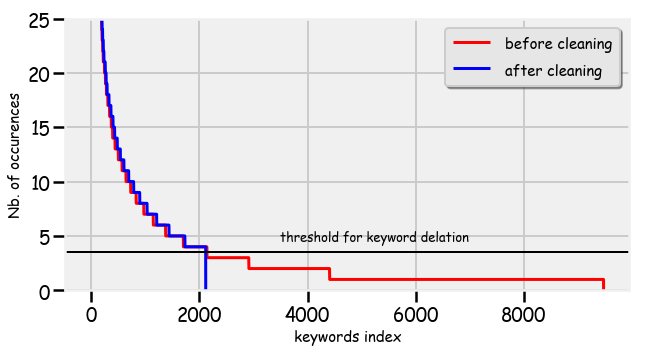

In [31]:
#----------------------------
font = {'family' : 'fantasy', 'weight' : 'normal', 'size'   : 15}
mpl.rc('font', **font)

keyword_occurences.sort(key = lambda x:x[1], reverse = True)

y_axis = [i[1] for i in keyword_occurences]
x_axis = [k for k,i in enumerate(keyword_occurences)]

new_y_axis = [i[1] for i in new_keyword_occurences]
new_x_axis = [k for k,i in enumerate(new_keyword_occurences)]

f, ax = plt.subplots(figsize=(9, 5))
ax.plot(x_axis, y_axis, 'r-', label='before cleaning')
ax.plot(new_x_axis, new_y_axis, 'b-', label='after cleaning')

# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('medium')
            
plt.ylim((0,25))
plt.axhline(y=3.5, linewidth=2, color = 'k')
plt.xlabel("keywords index", family='fantasy', fontsize = 15)
plt.ylabel("Nb. of occurences", family='fantasy', fontsize = 15)
#plt.suptitle("Nombre d'occurences des mots clés", fontsize = 18, family='fantasy')
plt.text(3500, 4.5, 'threshold for keyword delation', fontsize = 13)
plt.show()

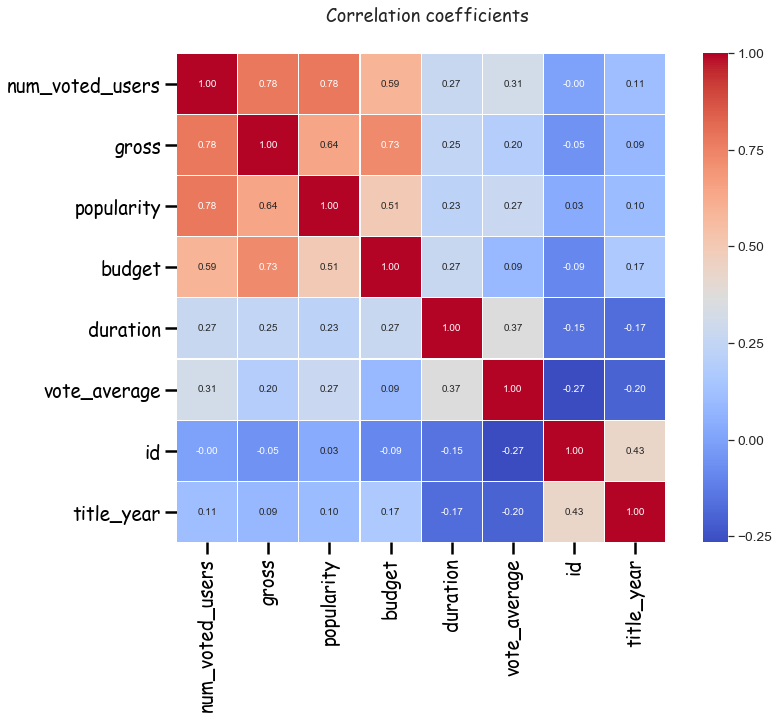

In [32]:
f, ax = plt.subplots(figsize=(12, 9))
#_____________________________
# calculations of correlations
corrmat = df_keywords_occurence.dropna(how='any').corr()
#________________________________________
k = 17 # number of variables for heatmap
cols = corrmat.nlargest(k, 'num_voted_users')['num_voted_users'].index
cm = np.corrcoef(df_keywords_occurence[cols].dropna(how='any').values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'coolwarm',
                 yticklabels=cols.values, xticklabels=cols.values)
f.text(0.5, 0.93, "Correlation coefficients", ha='center', fontsize = 18, family='fantasy')
plt.show()

In [33]:
df_var_cleaned = df_keywords_occurence.copy(deep = True)


In [34]:
missing_df = df_var_cleaned.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df_var_cleaned.shape[0] 
                                - missing_df['missing_count']) / df_var_cleaned.shape[0] * 100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
missing_df

,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3_name,93,98.063710
4,language,86,98.209452
5,actor_2_name,63,98.688320
6,actor_1_name,53,98.896523
7,director_name,30,99.375390
8,overview,3,99.937539
9,duration,2,99.958359


In [35]:
df_filling = df_var_cleaned.copy(deep=True)
missing_year_info = df_filling[df_filling['title_year'].isnull()][[
            'director_name','actor_1_name', 'actor_2_name', 'actor_3_name']]
missing_year_info[:10]

,director_name,actor_1_name,actor_2_name,actor_3_name
4553,NaN,NaN,NaN,NaN


In [36]:
df_filling.iloc[4553]


budget                                                                  0
genres                                                                   
homepage                                                              NaN
id                                                                 380097
plot_keywords                                                            
language                                                              NaN
original_title                                 America Is Still the Place
overview                1971 post civil rights San Francisco seemed li...
popularity                                                              0
production_companies                                                   []
production_countries                                                   []
release_date                                                          NaT
gross                                                                   0
duration                              

In [37]:
def fill_year(df):
    col = ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']
    usual_year = [0 for _ in range(4)]
    var        = [0 for _ in range(4)]
    #_____________________________________________________________
    # I get the mean years of activity for the actors and director
    for i in range(4):
        usual_year[i] = df.groupby(col[i])['title_year'].mean()
    #_____________________________________________
    # I create a dictionnary collectinf this info
    actor_year = dict()
    for i in range(4):
        for s in usual_year[i].index:
            if s in actor_year.keys():
                if pd.notnull(usual_year[i][s]) and pd.notnull(actor_year[s]):
                    actor_year[s] = (actor_year[s] + usual_year[i][s])/2
                elif pd.isnull(actor_year[s]):
                    actor_year[s] = usual_year[i][s]
            else:
                actor_year[s] = usual_year[i][s]
        
    #______________________________________
    # identification of missing title years
    missing_year_info = df[df['title_year'].isnull()]
    #___________________________
    # filling of missing values
    icount_replaced = 0
    for index, row in missing_year_info.iterrows():
        value = [ np.NaN for _ in range(4)]
        icount = 0 ; sum_year = 0
        for i in range(4):            
            var[i] = df.loc[index][col[i]]
            if pd.notnull(var[i]): value[i] = actor_year[var[i]]
            if pd.notnull(value[i]): icount += 1 ; sum_year += actor_year[var[i]]
        if icount != 0: sum_year = sum_year / icount 

        if int(sum_year) > 0:
            icount_replaced += 1
            df.set_value(index, 'title_year', int(sum_year))
            if icount_replaced < 10: 
                print("{:<45} -> {:<20}".format(df.loc[index]['movie_title'],int(sum_year)))
    return 

In [38]:
fill_year(df_filling)


In [39]:
icount = 0
for index, row in df_filling[df_filling['plot_keywords'].isnull()].iterrows():
    icount += 1
    liste_mot = row['movie_title'].strip().split()
    new_keyword = []
    for s in liste_mot:
        lemma = get_synonymes(s)
        for t in list(lemma):
            if t in keywords: 
                new_keyword.append(t)                
    if new_keyword and icount < 15: 
        print('{:<50} -> {:<30}'.format(row['movie_title'], str(new_keyword)))
    if new_keyword:
        df_filling.set_value(index, 'plot_keywords', '|'.join(new_keyword)) 

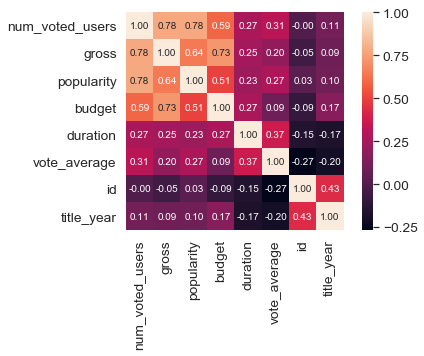

In [40]:
cols = corrmat.nlargest(9, 'num_voted_users')['num_voted_users'].index
cm = np.corrcoef(df_keywords_occurence[cols].dropna(how='any').values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

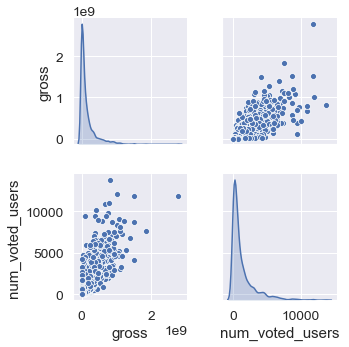

In [41]:
sns.set(font_scale=1.25)
cols = ['gross', 'num_voted_users']
sns.pairplot(df_filling.dropna(how='any')[cols],diag_kind='kde', size = 2.5)
plt.show();

In [42]:
def variable_linreg_imputation(df, col_to_predict, ref_col):
    regr = linear_model.LinearRegression()
    test = df[[col_to_predict,ref_col]].dropna(how='any', axis = 0)
    X = np.array(test[ref_col])
    Y = np.array(test[col_to_predict])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr.fit(X, Y)
    
    test = df[df[col_to_predict].isnull() & df[ref_col].notnull()]
    for index, row in test.iterrows():
        value = float(regr.predict(row[ref_col]))
        df.set_value(index, col_to_predict, value)

In [43]:
variable_linreg_imputation(df_filling, 'gross', 'num_voted_users')


In [44]:
df = df_filling.copy(deep = True)
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df.shape[0] 
                                - missing_df['missing_count']) / df.shape[0] * 100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
missing_df

,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3_name,93,98.063710
4,language,86,98.209452
5,actor_2_name,63,98.688320
6,actor_1_name,53,98.896523
7,director_name,30,99.375390
8,overview,3,99.937539
9,duration,2,99.958359


In [45]:
df = df_filling.copy(deep=True)
df.reset_index(inplace = True, drop = True)

In [46]:
gaussian_filter = lambda x,y,sigma: math.exp(-(x-y)**2/(2*sigma**2))


In [47]:
def entry_variables(df, id_entry): 
    col_labels = []    
    if pd.notnull(df['director_name'].iloc[id_entry]):
        for s in df['director_name'].iloc[id_entry].split('|'):
            col_labels.append(s)
            
    for i in range(3):
        column = 'actor_NUM_name'.replace('NUM', str(i+1))
        if pd.notnull(df[column].iloc[id_entry]):
            for s in df[column].iloc[id_entry].split('|'):
                col_labels.append(s)
                
    if pd.notnull(df['plot_keywords'].iloc[id_entry]):
        for s in df['plot_keywords'].iloc[id_entry].split('|'):
            col_labels.append(s)
    return col_labels

In [48]:
def add_variables(df, REF_VAR):    
    for s in REF_VAR: df[s] = pd.Series([0 for _ in range(len(df))])
    colonnes = ['genres', 'actor_1_name', 'actor_2_name',
                'actor_3_name', 'director_name', 'plot_keywords']
    for categorie in colonnes:
        for index, row in df.iterrows():
            if pd.isnull(row[categorie]): continue
            for s in row[categorie].split('|'):
                if s in REF_VAR: df.set_value(index, s, 1)            
    return df

In [49]:
def recommand(df, id_entry):    
    df_copy = df.copy(deep = True)    
    liste_genres = set()
    for s in df['genres'].str.split('|').values:
        liste_genres = liste_genres.union(set(s))    
    #_____________________________________________________
    # Create additional variables to check the similarity
    variables = entry_variables(df_copy, id_entry)
    variables += list(liste_genres)
    df_new = add_variables(df_copy, variables)
    #____________________________________________________________________________________
    # determination of the closest neighbors: the distance is calculated / new variables
    X = df_new.as_matrix(variables)
    nbrs = NearestNeighbors(n_neighbors=31, algorithm='auto', metric='euclidean').fit(X)

    distances, indices = nbrs.kneighbors(X)    
    xtest = df_new.iloc[id_entry].as_matrix(variables)
    xtest = xtest.reshape(1, -1)

    distances, indices = nbrs.kneighbors(xtest)

    return indices[0][:]

In [50]:
def extract_parameters(df, liste_films):     
    parametres_films = ['_' for _ in range(31)]
    i = 0
    max_users = -1
    for index in liste_films:
        parametres_films[i] = list(df.iloc[index][['movie_title', 'title_year',
                                        'imdb_score', 'num_user_for_reviews', 
                                        'num_voted_users']])
        parametres_films[i].append(index)
        max_users = max(max_users, parametres_films[i][4] )
        i += 1
        
    title_main = parametres_films[0][0]
    annee_ref  = parametres_films[0][1]
    parametres_films.sort(key = lambda x:critere_selection(title_main, max_users,
                                    annee_ref, x[0], x[1], x[2], x[4]), reverse = True)

    return parametres_films 

In [51]:
def sequel(titre_1, titre_2):    
    if fuzz.ratio(titre_1, titre_2) > 50 or fuzz.token_set_ratio(titre_1, titre_2) > 50:
        return True
    else:
        return False

In [52]:
def critere_selection(title_main, max_users, annee_ref, titre, annee, imdb_score, votes):    
    if pd.notnull(annee_ref):
        facteur_1 = gaussian_filter(annee_ref, annee, 20)
    else:
        facteur_1 = 1        

    sigma = max_users * 1.0

    if pd.notnull(votes):
        facteur_2 = gaussian_filter(votes, max_users, sigma)
    else:
        facteur_2 = 0
        
    if sequel(title_main, titre):
        note = 0
    else:
        note = imdb_score**2 * facteur_1 * facteur_2
    
    return note

In [53]:
def add_to_selection(film_selection, parametres_films):    
    film_list = film_selection[:]
    icount = len(film_list)    
    for i in range(31):
        already_in_list = False
        for s in film_selection:
            if s[0] == parametres_films[i][0]: already_in_list = True
            if sequel(parametres_films[i][0], s[0]): already_in_list = True            
        if already_in_list: continue
        icount += 1
        if icount <= 5:
            film_list.append(parametres_films[i])
    return film_list

In [54]:
def remove_sequels(film_selection):    
    removed_from_selection = []
    for i, film_1 in enumerate(film_selection):
        for j, film_2 in enumerate(film_selection):
            if j <= i: continue 
            if sequel(film_1[0], film_2[0]): 
                last_film = film_2[0] if film_1[1] < film_2[1] else film_1[0]
                removed_from_selection.append(last_film)

    film_list = [film for film in film_selection if film[0] not in removed_from_selection]

    return film_list   

In [55]:
def find_similarities(df, id_entry, del_sequels = True, verbose = False):    
    if verbose: 
        print(90*'_' + '\n' + "QUERY: films similar to id={} -> '{}'".format(id_entry,
                                df.iloc[id_entry]['movie_title']))
    #____________________________________
    liste_films = recommand(df, id_entry)
    #__________________________________
    # Create a list of 31 films
    parametres_films = extract_parameters(df, liste_films)
    #_______________________________________
    # Select 5 films from this list
    film_selection = []
    film_selection = add_to_selection(film_selection, parametres_films)
    #__________________________________
    # delation of the sequels
    if del_sequels: film_selection = remove_sequels(film_selection)
    #______________________________________________
    # add new films to complete the list
    film_selection = add_to_selection(film_selection, parametres_films)
    #_____________________________________________
    selection_titres = []
    for i,s in enumerate(film_selection):
        selection_titres.append([s[0].replace(u'\xa0', u''), s[5]])
        if verbose: print("nº{:<2}     -> {:<30}".format(i+1, s[0]))

    return selection_titres

In [61]:
import sys
# pip install fuzzywuzzy
%pip install python-Levenshtein
%pip install fuzzywuzzy


  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-win_amd64.whl size=85881 sha256=3aa088fb30f2aae48cf1598a5cffc722ae1f09d2fd45f76043296348fa63419a
  Stored in directory: C:\Users\ravi\AppData\Local\pip\Cache\wheels\de\c2\93\660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [62]:
from fuzzywuzzy import fuzz 


In [63]:
dum = find_similarities(df, 12, del_sequels = False, verbose = True)


__________________________________________________________________________________________
QUERY: films similar to id=12 -> 'Pirates of the Caribbean: Dead Man's Chest'
nº1      -> Pirates of the Caribbean: Dead Man's Chest
nº2      -> Pirates of the Caribbean: At World's End
nº3      -> Pirates of the Caribbean: The Curse of the Black Pearl
nº4      -> Pirates of the Caribbean: On Stranger Tides
nº5      -> Cutthroat Island              


In [64]:
dum = find_similarities(df, 12, del_sequels = True, verbose = True)


__________________________________________________________________________________________
QUERY: films similar to id=12 -> 'Pirates of the Caribbean: Dead Man's Chest'
nº1      -> Pirates of the Caribbean: The Curse of the Black Pearl
nº2      -> Cutthroat Island              
nº3      -> The Hobbit: An Unexpected Journey
nº4      -> The 13th Warrior              
nº5      -> Red Sonja                     


In [65]:
dum = find_similarities(df, 2, del_sequels = True, verbose = True)


__________________________________________________________________________________________
QUERY: films similar to id=2 -> 'Spectre'
nº1      -> Spectre                       
nº2      -> Skyfall                       
nº3      -> Quantum of Solace             
nº4      -> The Art of War                
nº5      -> Kick-Ass 2                    


In [66]:
selection = dict()
for i in range(0, 20, 3):
    selection[i] = find_similarities(df, i, del_sequels = True, verbose = True)

__________________________________________________________________________________________
QUERY: films similar to id=0 -> 'Avatar'
nº1      -> Avatar                        
nº2      -> Star Trek Into Darkness       
nº3      -> Jupiter Ascending             
nº4      -> The Fifth Element             
nº5      -> Pirates of the Caribbean: On Stranger Tides
__________________________________________________________________________________________
QUERY: films similar to id=3 -> 'The Dark Knight Rises'
nº1      -> The Dark Knight               
nº2      -> Batman & Robin                
nº3      -> Kick-Ass                      
nº4      -> Hitman                        
nº5      -> Running Scared                
__________________________________________________________________________________________
QUERY: films similar to id=6 -> 'Tangled'
nº1      -> Tangled                       
nº2      -> The Princess and the Frog     
nº3      -> Ponyo                         
nº4      -> Toy 